In [112]:
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from OSMPythonTools.nominatim import Nominatim
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass
import osmnx as ox
import matplotlib.pyplot as plt
ox.config(log_file=True, log_console=True, use_cache=True)

In [3]:
conn = psycopg2.connect(dbname="postgis", 
                 user="gsa2021", 
                 password="5HOA&yn6$B", 
                 host="192.168.212.99", 
                 port=32771)

In [14]:
nominatim = Nominatim()
areaId = nominatim.query('Luzon, Philippines').areaId()

[nominatim] downloading data: search


In [17]:
overpass = Overpass()
query = overpassQueryBuilder(area=areaId,
                             elementType='relation',
                             selector='"admin_level"="2.5"',
                             includeGeometry=True,out='body')
result = overpass.query(query)

[overpass] downloading data: [timeout:25][out:json];area(3600443174)->.searchArea;(relation["admin_level"="2.5"](area.searchArea);); out body geom;


In [19]:
result.elements()[0].tags()

{'admin_level': '2.5',
 'alt_name': 'Luzon Island Group',
 'boundary': 'administrative',
 'name': 'Luzon',
 'type': 'boundary',
 'wikidata': 'Q2673519',
 'wikipedia': 'nl:Luzon (eilandengroep)'}

In [42]:
df = pd.DataFrame(columns=['Name','geom'])
geo = gpd.read_file(str(result.elements()[0].geometry()))['geometry'][0]
df.loc[0] = [result.elements()[0].tag('name'),geo]
gdf = gpd.GeoDataFrame(df, geometry=df.geom)
gdf

,Name,geom,geometry
0,Luzon,"(POLYGON ((118.501564 7.62508, 118.564181 7.65...","MULTIPOLYGON (((118.50156 7.62508, 118.56418 7..."


<AxesSubplot:>

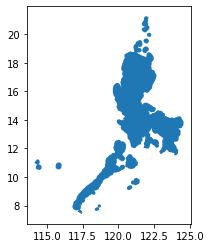

In [43]:
gdf.plot()

In [46]:
ph_shp = gpd.read_postgis('''
SELECT * 
FROM gadm.ph
''',conn,geom_col='geom')
ph_shp.head()

,gid,gid_0,name_0,gid_1,name_1,nl_name_1,gid_2,name_2,varname_2,nl_name_2,type_2,engtype_2,cc_2,hasc_2,geom
0,1,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.1_1,Bangued,None,None,Bayan|Munisipyo,Municipality,140101,PH.AB.BN,"MULTIPOLYGON (((120.62710 17.49300, 120.62177 ..."
1,2,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.2_1,Boliney,None,None,Bayan|Munisipyo,Municipality,140102,PH.AB.BL,"MULTIPOLYGON (((120.99042 17.39802, 120.98631 ..."
2,3,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.3_1,Bucay,None,None,Bayan|Munisipyo,Municipality,140103,PH.AB.BU,"MULTIPOLYGON (((120.70788 17.45395, 120.70621 ..."
3,4,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.4_1,Bucloc,None,None,Bayan|Munisipyo,Municipality,140104,PH.AB.BC,"MULTIPOLYGON (((120.78956 17.41699, 120.78922 ..."
4,5,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.5_1,Daguioman,None,None,Bayan|Munisipyo,Municipality,140105,PH.AB.DG,"MULTIPOLYGON (((120.92917 17.41307, 120.92464 ..."


<AxesSubplot:>

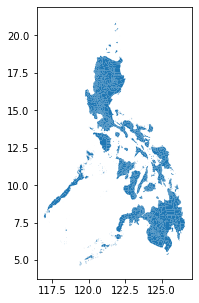

In [47]:
ph_shp.plot(figsize=(5,5))

In [95]:
luzon = gpd.overlay(gdf, ph_shp, how='intersection')

<ipython-input-95-b668629758d0>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  luzon = gpd.overlay(gdf, ph_shp, how='intersection')


<AxesSubplot:>

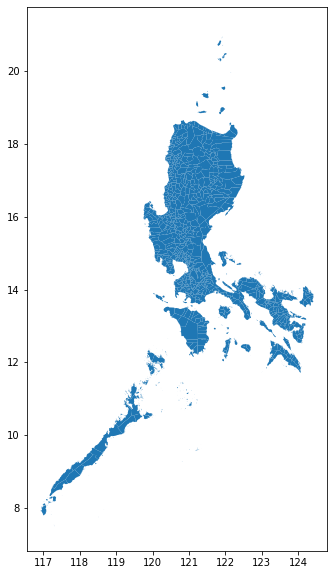

In [96]:
luzon.plot(figsize=(10,10))

In [98]:
luzon['centroid'] = luzon.centroid

df_luzon = luzon[['name_1','name_2','centroid']]
df_luzon  = gpd.GeoDataFrame(df_luzon , geometry=df_luzon.centroid)
df_luzon.head()

,name_1,name_2,centroid,geometry
0,Abra,Bangued,POINT (120.60718 17.60052),POINT (120.60718 17.60052)
1,Abra,Boliney,POINT (120.86822 17.37966),POINT (120.86822 17.37966)
2,Abra,Bucay,POINT (120.72253 17.52285),POINT (120.72253 17.52285)
3,Abra,Bucloc,POINT (120.84761 17.43768),POINT (120.84761 17.43768)
4,Abra,Daguioman,POINT (120.95165 17.45102),POINT (120.95165 17.45102)


<AxesSubplot:>

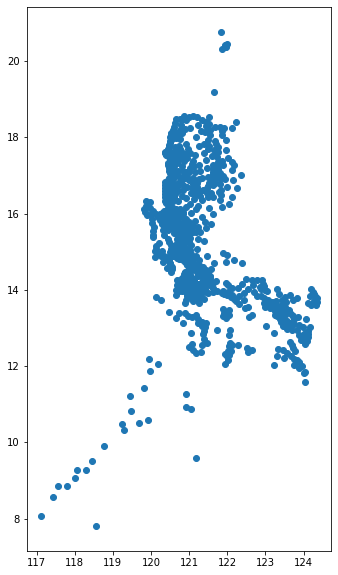

In [99]:
df_luzon.plot(figsize=(10,10))

In [100]:
pop = pd.read_csv('financial_pop.csv')
pop.head()

,pop,tot_local_sources,tot_tax_revenue,tot_current_oper_income,total_oper_expenses,net_oper_income,total_non_income_receipts,capital_expenditure,total_non_oper_expenditures,cash_balance_end,shp_province,shp_municipality
0,48163.0,74.045920,36.556294,230.577076,206.848717,23.728359,0.0,16.202464,21.181116,15.758681,Abra,Bangued
1,3573.0,0.115667,0.035633,56.689883,54.409910,2.279973,0.0,0.000000,0.030000,20.369743,Abra,Boliney
2,17115.0,1.736411,1.019565,93.647242,66.222389,27.424853,0.0,19.560034,20.792182,6.632671,Abra,Bucay
3,2501.0,0.273689,0.129150,44.789104,29.633181,15.155923,0.0,0.479569,0.656569,24.348356,Abra,Bucloc
4,2088.0,0.643801,0.277660,51.242322,47.848486,3.393836,0.0,0.000000,0.000000,6.511575,Abra,Daguioman


In [105]:
gdf_pop = df_luzon.merge(pop,left_on=['name_1','name_2'], right_on=['shp_province','shp_municipality'])
gdf_pop.head()

,name_1,name_2,centroid,geometry,pop,tot_local_sources,tot_tax_revenue,tot_current_oper_income,total_oper_expenses,net_oper_income,total_non_income_receipts,capital_expenditure,total_non_oper_expenditures,cash_balance_end,shp_province,shp_municipality
0,Abra,Bangued,POINT (120.60718 17.60052),POINT (120.60718 17.60052),48163.0,74.045920,36.556294,230.577076,206.848717,23.728359,0.0,16.202464,21.181116,15.758681,Abra,Bangued
1,Abra,Boliney,POINT (120.86822 17.37966),POINT (120.86822 17.37966),3573.0,0.115667,0.035633,56.689883,54.409910,2.279973,0.0,0.000000,0.030000,20.369743,Abra,Boliney
2,Abra,Bucay,POINT (120.72253 17.52285),POINT (120.72253 17.52285),17115.0,1.736411,1.019565,93.647242,66.222389,27.424853,0.0,19.560034,20.792182,6.632671,Abra,Bucay
3,Abra,Bucloc,POINT (120.84761 17.43768),POINT (120.84761 17.43768),2501.0,0.273689,0.129150,44.789104,29.633181,15.155923,0.0,0.479569,0.656569,24.348356,Abra,Bucloc
4,Abra,Daguioman,POINT (120.95165 17.45102),POINT (120.95165 17.45102),2088.0,0.643801,0.277660,51.242322,47.848486,3.393836,0.0,0.000000,0.000000,6.511575,Abra,Daguioman


In [110]:
gdf_pop = gdf_pop.dropna()

In [120]:
gdf_pop.drop(['centroid','shp_province','shp_municipality'],axis=1).to_csv('centroid_cities.csv',index=False)